## Import Libraries

In [1]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import pandas_ta
import numpy as np
import datetime as dt
import scipy.optimize as sco

import requests
import os
import json
from FiinQuantX import FiinSession

from dotenv import load_dotenv

In [2]:
client = FiinSession(
    username="DSTC_13@fiinquant.vn",
    password="Fiinquant0606",
).login()

fi = client.FiinIndicator()

## Download HOSE/HNX/UPCOM tickers

In [3]:
url = 'https://vi.wikipedia.org/wiki/Danh_s%C3%A1ch_c%C3%B4ng_ty_tr%C3%AAn_s%C3%A0n_giao_d%E1%BB%8Bch_ch%E1%BB%A9ng_kho%C3%A1n_Vi%E1%BB%87t_Nam'
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
raw_tickers = pd.read_html(response.text)

In [4]:
# Keys are tickers, values are stock exchange
ticker_list = []

raw_tickers[18].drop(columns=["Unnamed: 5"])

# Clean strip in columns
for i in range(len(raw_tickers)):
    if raw_tickers[i].columns.dtype != "int64":
        raw_tickers[i].columns = (
        raw_tickers[i].columns.str.strip()                 # remove spaces
        )  

    if i == 18:
          raw_tickers[i] = raw_tickers[i].drop(columns=["Unnamed: 5"])

# Uniform column name
for i in range(len(raw_tickers)):
    if (raw_tickers[i].shape[1] == 5) & (raw_tickers[i].columns.dtype != 'int64'):
        raw_tickers[i] = raw_tickers[i].rename(columns={
            "Mã": "ticker",
            "Tên tiếng Việt": "Company_VN",
            "Tên giao dịch tiếng Anh": "Company_EN",
            "Sàn giao dịch": "Exchange",
            "Ngày tham gia": "Date"
        })
    elif (raw_tickers[i].shape[1] == 3):
        raw_tickers[i] = raw_tickers[i].rename(columns={
            "CK": "ticker",
            "TÊN CÔNG TY": "Company_VN",
            "SÀN": "Exchange"
        })

    else:
        raw_tickers[i] = raw_tickers[i].rename(columns={
            0: "ticker",
            1: "Company_VN",
            2: "Company_EN",
            3: "Exchange",
            4: "Date"
        })

# Extract all tickers from exchanges
for i in range(len(raw_tickers)):
    ticker_list.extend(raw_tickers[i]["ticker"].dropna().tolist())

ticker_list = list(set(ticker_list))

print(len(ticker_list), ticker_list[:20])

1327 ['PTB', 'SEA', 'BLI', 'VCB', 'VIC', 'CNH', 'VMI', 'HMC', 'VJC', 'FTM', 'VFMVN30', 'POS', 'SBT', 'VIP', 'SAB', 'VNY', 'LM7', 'VNL', 'DOC', 'DNL']


In [5]:
len(list(set(pd.concat(raw_tickers, ignore_index=True).loc[:, "ticker"].to_list())))

1327

In [6]:
data = client.Fetch_Trading_Data(realtime = False,
                                  tickers = ticker_list,
                                  fields = "full",
                                  adjusted=True,
                                  by="1d",
                                  from_date="2023-01-01").get_data()

Fetching data, it may take a while. Please wait...


In [7]:
dups_mask = data.duplicated(['ticker','timestamp'], keep=False)
dups = data.loc[dups_mask].sort_values(['ticker','timestamp'])
print(dups)

       ticker         timestamp    open    high     low   close     volume  \
211285    HBC  2024-10-21 00:00  4900.0  5000.0  4900.0  4900.0   491500.0   
211286    HBC  2024-10-21 00:00  4900.0  5000.0  4900.0  4900.0   491500.0   
211287    HBC  2024-10-21 00:00  4900.0  5000.0  4900.0  4900.0   491500.0   
211288    HBC  2024-10-21 00:00  4900.0  5000.0  4900.0  4900.0   491500.0   
211289    HBC  2024-10-21 00:00  5000.0  5000.0  4900.0  4918.0   492800.0   
211290    HBC  2024-10-21 00:00  5000.0  5000.0  4900.0  4918.0   492800.0   
211291    HBC  2024-10-21 00:00  5000.0  5000.0  4900.0  4918.0   492800.0   
211292    HBC  2024-10-21 00:00  5000.0  5000.0  4900.0  4918.0   492800.0   
239165    HNG  2024-10-21 00:00  4500.0  4700.0  4500.0  4500.0  2053200.0   
239166    HNG  2024-10-21 00:00  4500.0  4700.0  4500.0  4500.0  2053200.0   
239167    HNG  2024-10-21 00:00  4500.0  4700.0  4500.0  4500.0  2053200.0   
239168    HNG  2024-10-21 00:00  4500.0  4700.0  4500.0  4500.0 

In [8]:
# Remove duplicates
data = data.drop_duplicates(subset=["ticker", 'timestamp'])

In [9]:
# Reference table with tickers and exchange
stock_ref = pd.concat(raw_tickers, ignore_index=True).loc[:, ["ticker", "Exchange"]]
stock_ref["ticker"] = stock_ref["ticker"].str.strip().str.upper()
stock_ref["Exchange"] = stock_ref["Exchange"].str.strip().str.upper().replace({"HSX":"HOSE"})
# if multiples exist, keep the last or pick a rule you like
dim_ticker = stock_ref.drop_duplicates(subset=["ticker"], keep="last")
print(data)

# Join two dataframes
data = data.merge(right = dim_ticker, how = "left", left_on="ticker", right_on="ticker")
data.to_csv("stock_data.csv", index=False)
print("Stock data saved stock_data.csv")


       ticker         timestamp          open          high           low  \
0         A32  2023-01-03 00:00  24472.273392  24472.273392  24472.273392   
1         A32  2023-01-04 00:00  24472.273392  24472.273392  24472.273392   
2         A32  2023-01-05 00:00  24472.273392  24472.273392  24472.273392   
3         A32  2023-01-06 00:00  24472.273392  24472.273392  24472.273392   
4         A32  2023-01-09 00:00  23499.865178  23499.865178  23499.865178   
...       ...               ...           ...           ...           ...   
711167    YBC  2025-08-27 00:00  11600.000000  11600.000000  11600.000000   
711168    YBC  2025-08-28 00:00  11500.000000  11600.000000  10500.000000   
711169    YBC  2025-08-29 00:00  10600.000000  10800.000000  10600.000000   
711170    YBC  2025-09-03 00:00  11600.000000  11600.000000  11000.000000   
711171    YBC  2025-09-04 00:00  10000.000000  11100.000000  10000.000000   

               close  volume      bu      sd   fb   fs   fn  
0       24472

## Data Cleaning

In [10]:
data = pd.read_csv("stock_data.csv", usecols=["ticker", "timestamp", "open", "high", "low", "close", "volume", "Exchange", "bu", "sd", "fb", "fs", "fn"])                                                                
data

,ticker,timestamp,open,high,low,close,volume,bu,sd,fb,fs,fn,Exchange
0,A32,2023-01-03 00:00,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
1,A32,2023-01-04 00:00,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
2,A32,2023-01-05 00:00,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
3,A32,2023-01-06 00:00,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
4,A32,2023-01-09 00:00,23499.865178,23499.865178,23499.865178,23499.865178,1600.0,0.0,1600.0,0.0,0.0,0.0,UPCOM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
711153,YBC,2025-08-27 00:00,11600.000000,11600.000000,11600.000000,11600.000000,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
711154,YBC,2025-08-28 00:00,11500.000000,11600.000000,10500.000000,11418.000000,2200.0,1900.0,300.0,0.0,0.0,0.0,UPCOM
711155,YBC,2025-08-29 00:00,10600.000000,10800.000000,10600.000000,10763.000000,1100.0,0.0,1100.0,0.0,0.0,0.0,UPCOM
711156,YBC,2025-09-03 00:00,11600.000000,11600.000000,11000.000000,11091.000000,1200.0,200.0,1000.0,0.0,0.0,0.0,UPCOM


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711158 entries, 0 to 711157
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ticker     711158 non-null  object 
 1   timestamp  711158 non-null  object 
 2   open       711154 non-null  float64
 3   high       711154 non-null  float64
 4   low        711154 non-null  float64
 5   close      711154 non-null  float64
 6   volume     711154 non-null  float64
 7   bu         710650 non-null  float64
 8   sd         710650 non-null  float64
 9   fb         711157 non-null  float64
 10  fs         711157 non-null  float64
 11  fn         711157 non-null  float64
 12  Exchange   711158 non-null  object 
dtypes: float64(10), object(3)
memory usage: 70.5+ MB


In [12]:
# Convert to datetime type
data["date"] = pd.to_datetime(data["timestamp"], format="mixed")
data.rename(columns={"sd": "standard_deviation"}, inplace=True)
data.set_index(["date"], inplace=True)

In [13]:
data

,ticker,timestamp,open,high,low,close,volume,bu,standard_deviation,fb,fs,fn,Exchange
date,,,,,,,,,,,,,
2023-01-03,A32,2023-01-03 00:00,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
2023-01-04,A32,2023-01-04 00:00,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
2023-01-05,A32,2023-01-05 00:00,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
2023-01-06,A32,2023-01-06 00:00,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
2023-01-09,A32,2023-01-09 00:00,23499.865178,23499.865178,23499.865178,23499.865178,1600.0,0.0,1600.0,0.0,0.0,0.0,UPCOM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-27,YBC,2025-08-27 00:00,11600.000000,11600.000000,11600.000000,11600.000000,0.0,0.0,0.0,0.0,0.0,0.0,UPCOM
2025-08-28,YBC,2025-08-28 00:00,11500.000000,11600.000000,10500.000000,11418.000000,2200.0,1900.0,300.0,0.0,0.0,0.0,UPCOM
2025-08-29,YBC,2025-08-29 00:00,10600.000000,10800.000000,10600.000000,10763.000000,1100.0,0.0,1100.0,0.0,0.0,0.0,UPCOM


## Technical Analysis

In [14]:
# Relative Strength Index
rsi = data.groupby('ticker').apply(
    lambda g: fi.rsi(g[['close']], window=14)
).reset_index().set_index(["date"])

data["rsi"] = rsi["close"]

In [15]:
bb_middle = data.groupby('ticker').apply(lambda g: fi.sma(g["close"], window=20)).reset_index().set_index(["date"])
data["bb_middle"] = bb_middle["close"]

In [16]:
# Creating SMA20, 50, 200
data['sma_5'] = data.groupby('ticker')['close'].transform(lambda x: x.rolling(5, min_periods=5).mean())

data['sma_10'] = data.groupby('ticker')['close'].transform(lambda x: x.rolling(10, min_periods=10).mean())

data['sma_20'] = data.groupby('ticker')['close'].transform(lambda x: x.rolling(20, min_periods=20).mean())

data['sma_50'] = data.groupby('ticker')['close'].transform(lambda x: x.rolling(50, min_periods=50).mean())

data['sma_200'] = data.groupby('ticker')['close'].transform(lambda x: x.rolling(200, min_periods=200).mean())

# Return close to close
# Our strategy is take the position and allocated weights from the close moment of day t-1 and stop gain at the close moment of day t.
data['return_cc'] = data.groupby('ticker')['close'].pct_change().fillna(0.0)

# Creating volatility
data['volatility'] = data.groupby('ticker')['return_cc'].rolling(20).std().reset_index(level=0, drop=True)

# Later, we use the data of volatility of previous days from t - 1 backwards
# to generate weights for day t, so we need to shift(1) volatility to avoid lookahead bias.
data['volatility'] = data.groupby('ticker')['volatility'].shift(1)

# Average volume 20 days
data['vol_ma20'] = data.groupby('ticker')['volume'].transform(lambda x: x.rolling(20).mean())

In [17]:
# Bollinger Bands
# volatility of price and determining potential high/low price levels in a trend.
bollinger_hband = data.groupby('ticker').apply(lambda g: fi.bollinger_hband(g['close'], window=20, window_dev=2)).rename_axis(index=['ticker', 'date']).rename("hband").reset_index()
bollinger_lband = data.groupby('ticker').apply(lambda g: fi.bollinger_lband(g['close'], window=20, window_dev=2)).rename_axis(index=['ticker', 'date']).rename("lband").reset_index()

In [18]:
macd_df = (data.groupby("ticker")["close"]
        .apply(lambda g: fi.macd(g))
        .rename_axis(index=['ticker', 'date'])
        .rename("macd")
        .reset_index())

In [19]:
atr_df = (data.groupby("ticker")[["high", "low", "close"]]
        .apply(lambda g: fi.atr(g['high'], g['low'], g['close'], window=14))
        .rename_axis(index=['ticker', 'date'])
        .rename("atr")
        .reset_index())

In [20]:
# Reset index of data to algn with sub dataframes
data.reset_index("date", inplace=True)

# Copy values
data["bb_hband"] = bollinger_hband["hband"]
data["bb_lband"] = bollinger_lband["lband"]
data["macd"] = macd_df["macd"]
data["atr"] = atr_df["atr"]
data["atr_pct"] = data["atr"] / data["close"]

In [21]:
data.columns

Index(['date', 'ticker', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'bu', 'standard_deviation', 'fb', 'fs', 'fn', 'Exchange', 'rsi',
       'bb_middle', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_200',
       'return_cc', 'volatility', 'vol_ma20', 'bb_hband', 'bb_lband', 'macd',
       'atr', 'atr_pct'],
      dtype='object')

In [22]:
data = data.set_index('date')

## Filtering methods: Filter which stocks have buy signals to buy each day

In [23]:
# Splitting data: Take 2023, 2024 as train data to optimise strategy, 2025 as test data
train_data = data[data.index < '2025-01-01'].copy()
test_data = data[data.index >= "2025-01-01"].copy()
crisis_period = data[(data.index >= '2025-04-03') & (data.index <= '2025-07-01')].copy()

# Download benchmark data
# Benchmark to be drawn on chart
benchmark = client.Fetch_Trading_Data(
    realtime=False,
    tickers=["VNINDEX", "VN30", "HNXINDEX", "UPCOMINDEX"],
    fields=["close"],
    adjusted=True,
    by="1d",
    from_date="2023-01-01"
).get_data()

benchmark.to_csv('benchmark.csv', index=True)

Fetching data, it may take a while. Please wait...


In [24]:
benchmark = pd.read_csv('benchmark.csv', index_col=0, parse_dates=True)
benchmark['date'] = pd.to_datetime(benchmark['timestamp'])
benchmark = benchmark.set_index('date')
benchmark_for_train =  benchmark[benchmark.index < '2025-01-01']
benchmark_for_test = benchmark[benchmark.index >= '2025-01-01']
benchmark_for_crisis = benchmark[(benchmark.index >= '2025-04-03') & (benchmark.index < '2025-07-01')]

In [25]:
# Filtering signals to be of stock each day
def filtering_signals(df):
    df['buy_signal'] = (df['sma_20'] > df['sma_50']) & (df['rsi'] < 30) & (df['volume'] > df['vol_ma20'])
    df['sell_signal'] = (df['sma_20'] < df['sma_50']) & (df['rsi'] > 70) & (df['volume'] > df['vol_ma20'])
    return df

In [26]:
# Generating position, we can only long in VN market, so sell_signal we just set the position to be 0
def create_position(df: pd.DataFrame):
    df['position'] = 0 
    df.loc[df['buy_signal'], 'position'] = 1
    df.loc[df['sell_signal'], 'position'] = 0
    
    # As we use the data of previous days from t - 1 backwards to predict the signals of day t, we need to shift(1) position to avoid lookahead bias.
    df['position'] = df.groupby('ticker')['position'].shift(1).fillna(0).astype(int)
    return df

## Portfolio weight allocation

In [27]:
# Function to calculate weights based on inverse volatility of each day
# As we already shift(1) position of volatility, we can directly use the volatility of that day to calculate weight without lookahead bias
def votality_backward_weight_strategy(data: pd.DataFrame):
    # if position = 0, we don't care about its weight, as we only care about stocks with position = 1 to long
    subset = data[data['position'] != 0].copy()
    if subset.empty:
        return pd.Series(0.0, index=data.index)

    # calcuate inverse volatility
    subset['inv_volatility'] = 1.0 / subset['volatility'].replace(0, np.nan)

    # normalize weights so that they sum to 1
    subset['weight'] = subset['inv_volatility'] / subset['inv_volatility'].sum()

    # Reindex to original data to fill in zeros for stocks not in subset
    weights = pd.Series(0.0, index=data.index)
    weights.loc[subset.index] = subset['weight']
    
    return weights

## Backtest and Chart Function

In [28]:
# Create backtest function to calculate metrics

def back_test(df):
    # Loop each day to calculate weights of the day
    for date in df['date'].unique():
        mask = df['date'] == date
        df.loc[mask, 'weight'] = votality_backward_weight_strategy(df[mask])

    # strategy return (%) of each stock each day if we take position with weights allocated 
    df['strategy_return'] = df['position'] * df['return_cc'] * df['weight']
    
    # Return of the portfolio (%) each day (sum of strategy returns of all stocks that day) when we trade with the position and allocated weights everyday.
    daily_ret = df.groupby('date')['strategy_return'].sum().fillna(0.0).reset_index()

    # Number the days (convert to numpy array or Series) 
    daily_ret['day_num'] = np.arange(1, len(daily_ret) + 1)

    # As the stock market in Vietnam we can receive money after 2 days of trade, so if we allocate booksize to trade on day T
    # we will only get back the return on day T + 2 and continue to trade on day T + 2, T + 4, ...
    # So we can only trade on the odd days (1, 3, 5, ...)
    daily_ret = daily_ret[daily_ret['day_num'] % 3 == 1]

    # Series
    daily_ret = daily_ret.set_index('date')['strategy_return']

    # equity curve
    equity = (1 + daily_ret).cumprod()

    # metrics
    cum_return = equity.iloc[-1] - 1
    rf_annual = 0.03783   
    rf_daily = (1 + rf_annual)**(1/252) - 1
    sharpe = ((daily_ret.mean() - rf_daily) / daily_ret.std()) * np.sqrt(252)
    max_dd = (equity / equity.cummax() - 1).min()

    # Annualized Return 
    # Create a full schedule of business days in the range, fill missing days with 0 (for T+2 settlement)
    full_days = pd.date_range(start=daily_ret.index.min(), end=daily_ret.index.max(), freq='B')  # business days
    daily_ret_full = daily_ret.reindex(full_days, fill_value=0.0)
    equity_full = (1 + daily_ret_full).cumprod()
    
    # Annualized return calculation based on 252 trading days / year
    ann_return = equity_full.iloc[-1]**(252 / max(len(daily_ret_full), 1)) - 1


    # trades, win-rate
    daily_trades = df[df['weight'] != 0].groupby('date').size()
    total_trades = int(daily_trades.sum())
    avg_trades_per_day = float(daily_trades.mean()) if len(daily_trades) else 0.0
    daily_win_rate = (daily_ret > 0).mean()

    # === In kết quả ===
    print(f"Cumulative Return: {cum_return:.2%}")
    print(f"Annualized Return: {ann_return:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Average Trades per Day: {avg_trades_per_day:.2f}")
    print(f"Daily Win Rate: {daily_win_rate:.2%}")


In [ ]:
import matplotlib.pyplot as plt

def compare_chart(df, benchmark):
    # Equity curve (PnL tích lũy)
    daily_ret = df.groupby('date')['strategy_return'].sum().fillna(0.0).reset_index()

    # Indexing
    daily_ret['day_num'] = np.arange(1, len(daily_ret) + 1)

    # Keep odd
    daily_ret = daily_ret[daily_ret['day_num'] % 3 == 1]

    # Đưa về Series
    daily_ret = daily_ret.set_index('date')['strategy_return']
    
    full_days = pd.date_range(start=daily_ret.index.min(), end=daily_ret.index.max(), freq='B')  # business days
    daily_ret_full = daily_ret.reindex(full_days, fill_value=0.0)
    equity_full = (1 + daily_ret_full).cumprod()

    plt.figure(figsize=(12,6))
    plt.plot(equity_full.index, equity_full.values, label="Strategy Equity Curve vs Benchmark (Normalized)", color='blue')
    for bm in benchmark["ticker"].unique():
        bm_data = benchmark[benchmark["ticker"] == bm].copy()
        bm_data = bm_data.sort_index()

        # chuẩn hoá close
        bm_data["norm_close"] = bm_data["close"] / bm_data["close"].iloc[0]

        plt.plot(bm_data.index, bm_data["norm_close"], label=f"Benchmark {bm}", linestyle="--")
    # original line
    plt.axhline(1.0, color='black', linestyle='--', linewidth=1)

    plt.title("Equity Curve vs Benchmarks (Normalized to 1.0)")
    plt.xlabel("Date")
    plt.ylabel("Normalized Portfolio Value (Start = 1.0)")
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Backtest on train to fix and optimize strategy then backtest on test set to check whether it performs well on unseen data, backtest on crisis period to see whether it is negatively effects when the market went down 

Cumulative Return: 136.65%
Annualized Return: 51.69%
Sharpe Ratio: 3.59
Max Drawdown: -10.91%
Total Trades: 1360
Average Trades per Day: 3.33
Daily Win Rate: 38.92%


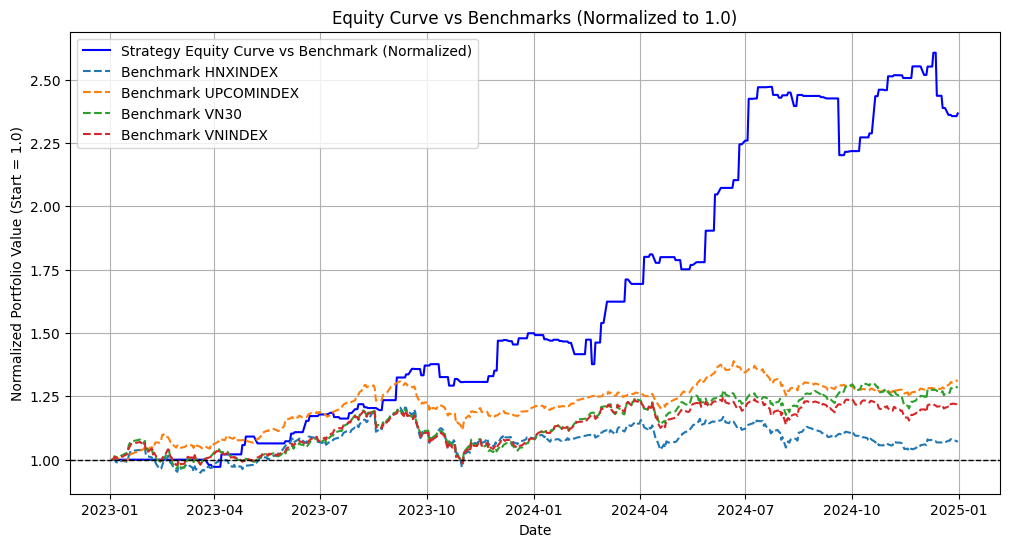

In [34]:
train_data = filtering_signals(train_data)
train_data = create_position(train_data)
# Sort ticker by each date
train_data = train_data.sort_values(by=["date", "ticker"]).reset_index(drop=False)
train_data["weight"] = 0

back_test(train_data)
compare_chart(train_data, benchmark_for_train)

Cumulative Return: 39.60%
Annualized Return: 63.03%
Sharpe Ratio: 3.14
Max Drawdown: -15.62%
Total Trades: 741
Average Trades per Day: 4.94
Daily Win Rate: 47.27%


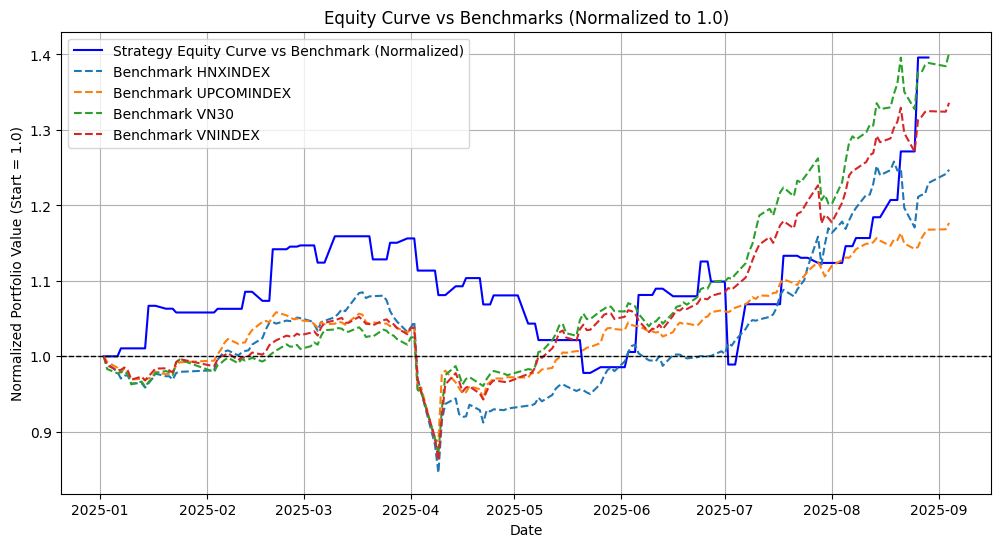

In [35]:
test_data = filtering_signals(test_data)
test_data = create_position(test_data)
# Sort ticker by each date
test_data = test_data.sort_values(by=["date", "ticker"]).reset_index(drop=False)
test_data["weight"] = 0

back_test(test_data)
compare_chart(test_data, benchmark_for_test)

Cumulative Return: -1.31%
Annualized Return: -5.21%
Sharpe Ratio: -0.26
Max Drawdown: -12.18%
Total Trades: 401
Average Trades per Day: 8.18
Daily Win Rate: 40.00%


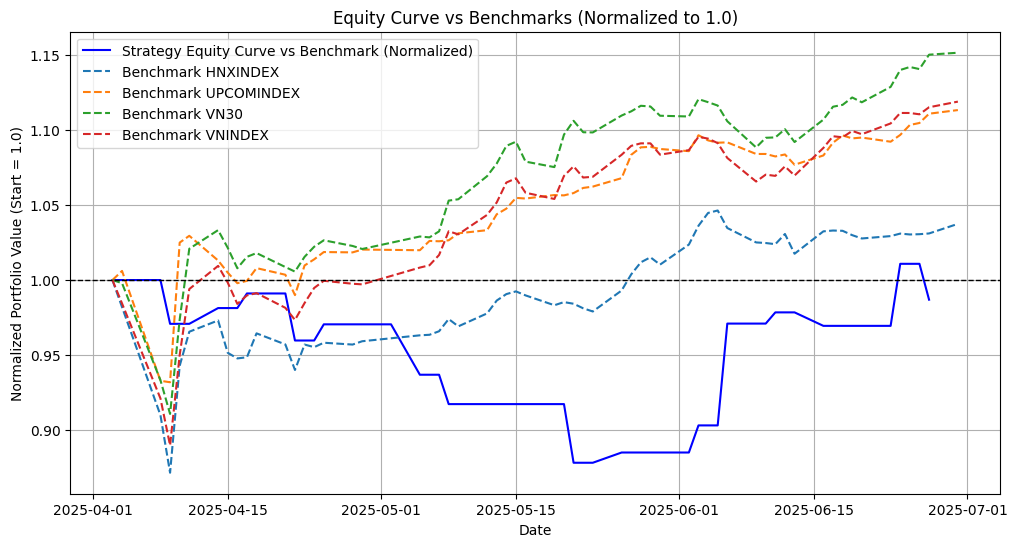

In [36]:
crisis_period = filtering_signals(crisis_period)
crisis_period = create_position(crisis_period)
# Sort ticker by each date
crisis_period = crisis_period.sort_values(by=["date", "ticker"]).reset_index(drop=False)
crisis_period["weight"] = 0

back_test(crisis_period)
compare_chart(crisis_period, benchmark_for_crisis)

## 